<a href="https://colab.research.google.com/github/ezgimez/dl-demos/blob/main/demo6_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Images using an Elman RNN and an LSTM 

In this demo we will use recurrent neural nets (RNNs) for a slightly non-standard application: image classification. To be clear, RNN-type architectures have been typically used for applications involving sequences (such as text, audio, time series, etc.)

For text applications, one has to somehow transform a sequence of characters into a sequence of numerical (vector) *encodings*. We will get into encodings in a later demo. 

Image data, on the other hand, is already in vector form. Let us imagine a setting where the pixels of an image are presented to the classifier in sequential form. Think of a problem where an image is being "raster-scanned", and where the classifier has to continuously updates its beliefs as new pixels come in. We will use a recurrent neural network to solve this problem.

Vanilla RNN models (e.g. Elman RNN) is known to suffer from _vanishing gradient problem_(i.e. gradient value becomes smaller and smaller, thus you stop 'learning'/updating the parameters). However, LSTM (and GRU) architectures seem to address this issue.

(An intuitive explanation of LSTMs can be found [here](https://www.youtube.com/watch?v=8HyCNIVRbSU&t=209s).)



# Data loading and preparation

We will use the familiar Fashion-MNIST dataset. The following code (until building the data-loader) should be standard.

In [14]:
from torch import nn
import torch.nn.functional as F

In [1]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()

)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



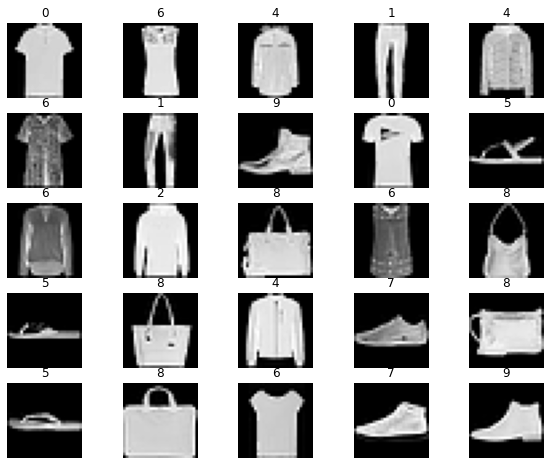

In [7]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() # sampling a random id from training data
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
from torch.utils.data import DataLoader
dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

# `num_workers` denote number of processes that generate batches in parallel.
# for example, `num_workers=0` means ONLY the main process loads the batches (not ideal..)
# ideally, the gerater the `num_workers` value is, the more efficiently CPU loads the data and..
# the less GPU has to, therefore, wait. HOwever, the optimal `num_workers` is not always clear, but is in most cases
# around 2-4.

# The performance of high `num_workers` are very relative -- depends on the batch size and the machine.
# As a starting point, you can start off your `num_workers` value equal to the number of CPU cores.
# More info: https://pytorch-lightning.readthedocs.io/en/latest/guides/speed.html

# Setting up the Elman RNN & LSTM model

Recall that FashionMNIST images are of size $28 \times 28$. We will pretend that each row of any input image is a token (of length 28), which is presented sequentially to the LSTM. Therefore there are 28 such tokens for each sequence (image).

You can read more about `tokenization` [here](https://d2l.ai/chapter_recurrent-neural-networks/text-preprocessing.html).

We will assume [Elman RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) recurrent units with 2 layers and hidden unit size 128


We will assume [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) recurrent units with 2 layers and hidden size 128.

Both networks will be followed by an output linear layer that performs the classification.


In [28]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 4 # make this 4 when you have some plenty of time
learning_rate = 0.01

The key is to set up the RNN correctly. Note that the length of the sequence is irrelevant to the model: it can process sequences of any length wrt. token size defined.

In [32]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # `batch_size` comes first because of `batch_first=True` argument passed to nn.RNN 
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
        
        
model_RNN = RNN(input_size, hidden_size, num_layers, num_classes)
print(model_RNN)

RNN(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
        
        
model_LSTM = LSTM(input_size, hidden_size, num_layers, num_classes)
print(model_LSTM)

LSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


# Training the RNN model

Everything looks good! Let us now train the model using the (familiar) cross-entropy loss and the Adam optimizer. 

We will use backpropagation-through-time (BPTT), which Pytorch automatically handles under the hood while calling `optimizer_backward()`.


In [33]:
loss_func = nn.CrossEntropyLoss()
from torch import optim
optimizer = optim.Adam(model_RNN.parameters(), lr = 0.01) 

In [34]:
def train(num_epochs, model, loaders):
        
    # Train the model
    total_step = len(dataloaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(dataloaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size)
            
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0: # having printouts after processing every 100 data samples
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                


train(num_epochs, model_RNN, dataloaders)

Epoch [1/4], Step [100/600], Loss: 2.32
Epoch [1/4], Step [200/600], Loss: 2.34
Epoch [1/4], Step [300/600], Loss: 2.05
Epoch [1/4], Step [400/600], Loss: 2.00
Epoch [1/4], Step [500/600], Loss: 2.09
Epoch [1/4], Step [600/600], Loss: 1.91
Epoch [2/4], Step [100/600], Loss: 1.90
Epoch [2/4], Step [200/600], Loss: 1.90
Epoch [2/4], Step [300/600], Loss: 2.00
Epoch [2/4], Step [400/600], Loss: 1.91
Epoch [2/4], Step [500/600], Loss: 1.85
Epoch [2/4], Step [600/600], Loss: 1.95
Epoch [3/4], Step [100/600], Loss: 1.92
Epoch [3/4], Step [200/600], Loss: 1.99
Epoch [3/4], Step [300/600], Loss: 2.04
Epoch [3/4], Step [400/600], Loss: 2.00
Epoch [3/4], Step [500/600], Loss: 1.94
Epoch [3/4], Step [600/600], Loss: 2.06
Epoch [4/4], Step [100/600], Loss: 2.16
Epoch [4/4], Step [200/600], Loss: 1.84
Epoch [4/4], Step [300/600], Loss: 2.08
Epoch [4/4], Step [400/600], Loss: 2.00
Epoch [4/4], Step [500/600], Loss: 1.99
Epoch [4/4], Step [600/600], Loss: 1.91


# Testing the RNN

Let's test the model now. 

In [35]:
model_RNN.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = images.reshape(-1, sequence_length, input_size)
        outputs = model_RNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test accuracy: {} %'.format(100 * correct / total))

Test accuracy: 19.72 %


Text accuracy is slightly better than random case (which is 10% since there are 10 classes).

# Training the LSTM model

Now, let's train and test LSTM model in the exactly same fashion.


In [38]:
optimizer = optim.Adam(model_LSTM.parameters(), lr = 0.01) 
train(num_epochs, model_LSTM, dataloaders)

Epoch [1/4], Step [100/600], Loss: 1.01
Epoch [1/4], Step [200/600], Loss: 0.93
Epoch [1/4], Step [300/600], Loss: 0.77
Epoch [1/4], Step [400/600], Loss: 0.65
Epoch [1/4], Step [500/600], Loss: 0.52
Epoch [1/4], Step [600/600], Loss: 0.49
Epoch [2/4], Step [100/600], Loss: 0.53
Epoch [2/4], Step [200/600], Loss: 0.42
Epoch [2/4], Step [300/600], Loss: 0.47
Epoch [2/4], Step [400/600], Loss: 0.38
Epoch [2/4], Step [500/600], Loss: 0.44
Epoch [2/4], Step [600/600], Loss: 0.36
Epoch [3/4], Step [100/600], Loss: 0.42
Epoch [3/4], Step [200/600], Loss: 0.48
Epoch [3/4], Step [300/600], Loss: 0.42
Epoch [3/4], Step [400/600], Loss: 0.29
Epoch [3/4], Step [500/600], Loss: 0.35
Epoch [3/4], Step [600/600], Loss: 0.30
Epoch [4/4], Step [100/600], Loss: 0.24
Epoch [4/4], Step [200/600], Loss: 0.26
Epoch [4/4], Step [300/600], Loss: 0.47
Epoch [4/4], Step [400/600], Loss: 0.31
Epoch [4/4], Step [500/600], Loss: 0.43
Epoch [4/4], Step [600/600], Loss: 0.28


In [40]:
model_LSTM.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = images.reshape(-1, sequence_length, input_size)
        outputs = model_LSTM(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test accuracy: {} %'.format(100 * correct / total))

Test accuracy: 87.71 %


Not too bad! We get ~88% accuracy on FashionMNIST where the pixels are presented sequentially, which is comparable to what we got using regular dense architectures.

In [58]:
sample = next(iter(dataloaders['test'])) # sample some test batch..
imgs, lbls = sample
# print(imgs.shape)

In [52]:
test_output = model_LSTM(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy()
# torch.max returns tuple (max, max_indices)
# [1] is to get the indices that that have max value.
labels = lbls[:10].numpy()
print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")

Predicted label: [1 8 0 7 6 0 4 8 0 8]
Actual label: [6 8 0 7 2 0 4 8 6 8]


Not too bad! We get ~88% accuracy on FashionMNIST where the pixels are presented sequentially, which is comparable to what we got using regular dense architectures.

Notice that LSTM architecture performed significantly better than Elman RNN. (Why?)

An advantage of RNN-based classification for images is that since RNNs work for variable-length inputs, it allows for declaring a class label even if the input is partially available (for example, if only the top one-third of the pixels were rasterized). Let's see how this would work.

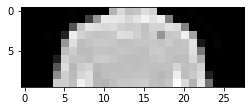

Predicted label: [4]
Actual label: 4


In [71]:
idx = 4
img = imgs[idx]
num_rows = 10
img_crop = img[:,:num_rows,:]
test_output_on_crop = model_LSTM(img_crop.view(-1, num_rows, 28)) 
# observe that in the line above, we are now giving the 'cropped' image

predicted = torch.max(test_output_on_crop, 1)[1].data.numpy()
labels = lbls[idx].numpy()

# plotting
figure = plt.figure(figsize=(4, 4))
plt.imshow(img_crop.squeeze(),cmap='gray')
plt.show()

print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")